In [ ]:
!pip install yfinance
!pip install lightgbm
!pip install mplfinance

In [1]:
import yfinance as yf
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from collections import deque
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [3]:
#### Get Data

# Define multiple symbols
symbols = ['AAPL', 'SPY', 'QQQ', 'DX-Y.NYB']

# Define the date range
start_date = '2009-01-01'
end_date = '2025-02-10'

# Download the data
df = yf.download(symbols, start=start_date, end=end_date, group_by='ticker')

# Convert to CSV file
# df.to_csv('historical_stock_data.csv')

[*********************100%***********************]  4 of 4 completed


In [5]:
# Inspect Data
df.describe()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4054 entries, 2009-01-02 to 2025-02-07
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (DX-Y.NYB, Open)    4052 non-null   float64
 1   (DX-Y.NYB, High)    4052 non-null   float64
 2   (DX-Y.NYB, Low)     4052 non-null   float64
 3   (DX-Y.NYB, Close)   4052 non-null   float64
 4   (DX-Y.NYB, Volume)  4052 non-null   float64
 5   (SPY, Open)         4051 non-null   float64
 6   (SPY, High)         4051 non-null   float64
 7   (SPY, Low)          4051 non-null   float64
 8   (SPY, Close)        4051 non-null   float64
 9   (SPY, Volume)       4051 non-null   float64
 10  (QQQ, Open)         4051 non-null   float64
 11  (QQQ, High)         4051 non-null   float64
 12  (QQQ, Low)          4051 non-null   float64
 13  (QQQ, Close)        4051 non-null   float64
 14  (QQQ, Volume)       4051 non-null   float64
 15  (AAPL, Open)        4051 non-null   f

Ticker       DX-Y.NYB                                                SPY  \
Price            Open       High        Low      Close Volume       Open   
Date                                                                       
2009-01-02  81.070000  81.919998  80.910004  81.839996    0.0  67.097834   
2009-01-05  81.559998  83.169998  81.339996  82.639999    0.0  68.722583   
2009-01-06  82.599998  84.019997  82.430000  82.849998    0.0  69.471940   
2009-01-07  82.860001  83.269997  81.629997  82.279999    0.0  68.255159   
2009-01-08  82.279999  82.660004  81.180000  81.540001    0.0  66.890095   

Ticker                                                          QQQ  \
Price            High        Low      Close       Volume       Open   
Date                                                                  
2009-01-02  69.323547  66.660107  68.967430  227566300.0  25.842605   
2009-01-05  69.486749  68.173576  68.885803  240349700.0  26.780763   
2009-01-06  70.072881  68.759712  69.345818  328260900.0  27.145607   
2009-01-07  68.448055  66.919729  67.268425  280899200.0  26.693893   
2009-01-08  67.580061  66.526558  67.542969  263834400.0  26.389860   

Ticker                                                        AAPL            \
Price            High        Low      Close       Volume      Open      High   
Date                                                                           
2009-01-02  27.041353  25.790486  26.954489  107891500.0  2.584439  2.739722   
2009-01-05  27.215092  26.572285  26.945808   91751900.0  2.803821  2.894403   
2009-01-06  27.475696  27.023995  27.215099  136791700.0  2.887481  2.924194   
2009-01-07  26.841565  26.224818  26.441982  133879800.0  2.762893  2.783657   
2009-01-08  26.754697  26.129263  26.719952  131926600.0  2.721364  2.803219   

Ticker                                        
Price            Low     Close        Volume  
Date                                          
2009-01-02  2.562772  2.730994  7.460152e+08  
2009-01-05  2.789978  2.846253  1.181608e+09  
2009-01-06  2.780347  2.799306  1.289310e+09  
2009-01-07  2.716248  2.738818  7.530488e+08  
2009-01-08  2.709627  2.789676  6.735008e+08

In [7]:
# Flatten the multi-index
df.columns = ['_'.join(col).strip() for col in df.columns.values]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4054 entries, 2009-01-02 to 2025-02-07
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DX-Y.NYB_Open    4052 non-null   float64
 1   DX-Y.NYB_High    4052 non-null   float64
 2   DX-Y.NYB_Low     4052 non-null   float64
 3   DX-Y.NYB_Close   4052 non-null   float64
 4   DX-Y.NYB_Volume  4052 non-null   float64
 5   SPY_Open         4051 non-null   float64
 6   SPY_High         4051 non-null   float64
 7   SPY_Low          4051 non-null   float64
 8   SPY_Close        4051 non-null   float64
 9   SPY_Volume       4051 non-null   float64
 10  QQQ_Open         4051 non-null   float64
 11  QQQ_High         4051 non-null   float64
 12  QQQ_Low          4051 non-null   float64
 13  QQQ_Close        4051 non-null   float64
 14  QQQ_Volume       4051 non-null   float64
 15  AAPL_Open        4051 non-null   float64
 16  AAPL_High        4051 non-null   float64
 

In [11]:
# Drop Unused Columns
df.drop(columns=['DX-Y.NYB_Volume', 'DX-Y.NYB_Open', 'DX-Y.NYB_High', 'DX-Y.NYB_Low', 'SPY_Open', 'QQQ_Open'], inplace=True)

In [13]:
# Count NaN values per column
nan_per_column = df.isna().sum()

# Count inf values per column
inf_per_column = np.isinf(df).sum()

# Display both
print("NaN values per column:")
print(nan_per_column)

print("\nInfinity values per column:")
print(inf_per_column)

NaN values per column:
DX-Y.NYB_Close    2
SPY_High          3
SPY_Low           3
SPY_Close         3
SPY_Volume        3
QQQ_High          3
QQQ_Low           3
QQQ_Close         3
QQQ_Volume        3
AAPL_Open         3
AAPL_High         3
AAPL_Low          3
AAPL_Close        3
AAPL_Volume       3
dtype: int64

Infinity values per column:
DX-Y.NYB_Close    0
SPY_High          0
SPY_Low           0
SPY_Close         0
SPY_Volume        0
QQQ_High          0
QQQ_Low           0
QQQ_Close         0
QQQ_Volume        0
AAPL_Open         0
AAPL_High         0
AAPL_Low          0
AAPL_Close        0
AAPL_Volume       0
dtype: int64


In [15]:
# Replace all inf values (+inf and -inf) with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows where any column has NaN
df.dropna(inplace=True)

# Reset index after dropping rows (optional)
#df.reset_index(drop=True, inplace=True)

In [19]:
df.describe()

,DX-Y.NYB_Close,SPY_High,SPY_Low,SPY_Close,SPY_Volume,QQQ_High,QQQ_Low,QQQ_Close,QQQ_Volume,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Volume
count,4049.000000,4049.000000,4049.000000,4049.000000,4.049000e+03,4049.000000,4049.000000,4049.000000,4.049000e+03,4049.000000,4049.000000,4049.000000,4049.000000,4.049000e+03
mean,91.572690,241.095085,238.377476,239.834479,1.198011e+08,173.108616,170.547921,171.919595,4.993675e+07,64.588982,65.270823,63.944151,64.640135,2.499674e+08
std,9.635852,139.011890,137.553431,138.335410,7.833890e+07,132.555458,130.542799,131.614197,3.287629e+07,66.418464,67.117756,65.775714,66.488660,2.325242e+08
min,72.930000,51.933269,49.781776,50.531071,2.027000e+07,23.288740,22.263723,22.359276,7.079300e+06,2.389131,2.467675,2.353320,2.353320,2.323470e+07
25%,81.370003,118.794478,117.905989,118.713699,6.767800e+07,61.250965,60.673592,61.019974,2.772340e+07,15.969903,16.183737,15.756292,15.961042,8.700000e+07
50%,93.860001,199.224605,198.191032,198.918060,9.570810e+07,116.877189,116.073765,116.499100,4.049220e+07,29.380986,29.702585,29.165081,29.465593,1.519481e+08
75%,98.379997,358.403268,350.924946,354.298553,1.473005e+08,280.530960,275.084352,277.956360,6.111950e+07,122.713159,123.952871,121.449101,122.762161,3.563168e+08
max,114.110001,610.780029,606.799988,609.750000,7.178287e+08,538.282053,533.270084,537.303589,2.882004e+08,257.906429,259.814335,257.347047,258.735504,1.880998e+09


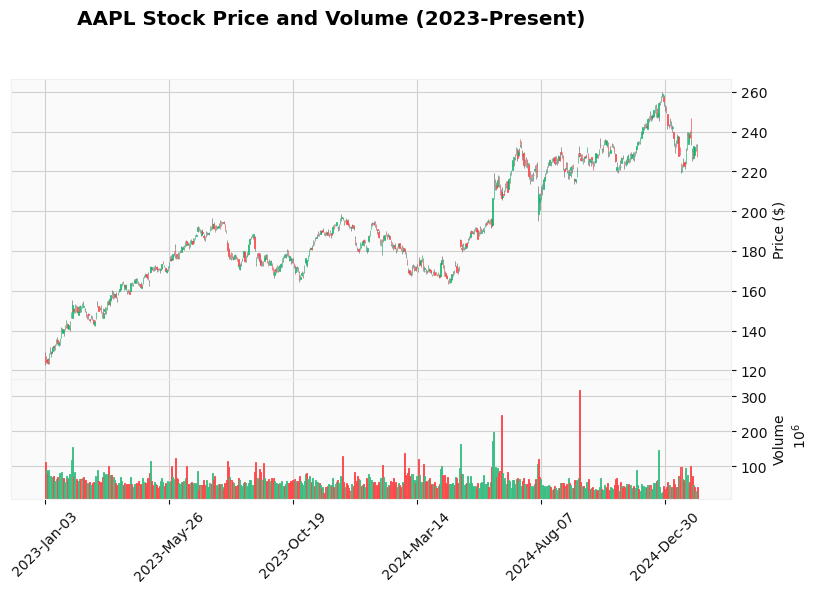

In [17]:
### Visualize Taget Data

# Filter AAPL columns and date range
plot_df = df[['AAPL_Open', 'AAPL_High', 'AAPL_Low', 'AAPL_Close', 'AAPL_Volume']].copy()
plot_df.index = pd.to_datetime(df.index)

# Filter data from 2023 to present
plot_df = plot_df.loc[plot_df.index >= '2023-01-01']

# Rename columns to match mplfinance's expected format
plot_df.rename(columns={
    'AAPL_Open': 'Open',
    'AAPL_High': 'High',
    'AAPL_Low': 'Low',
    'AAPL_Close': 'Close',
    'AAPL_Volume': 'Volume'
}, inplace=True)

# Create Chart
mpf.plot(
    plot_df,
    type='candle',               
    volume=True,                 
    style='yahoo',               
    title='AAPL Stock Price and Volume (2023-Present)',
    ylabel='Price ($)',
    ylabel_lower='Volume',
    figsize=(10, 6)
)


ADF Statistic: 1.1525146451755728
p-value: 0.9956408087773172
The time series is non-stationary. Differencing is needed.


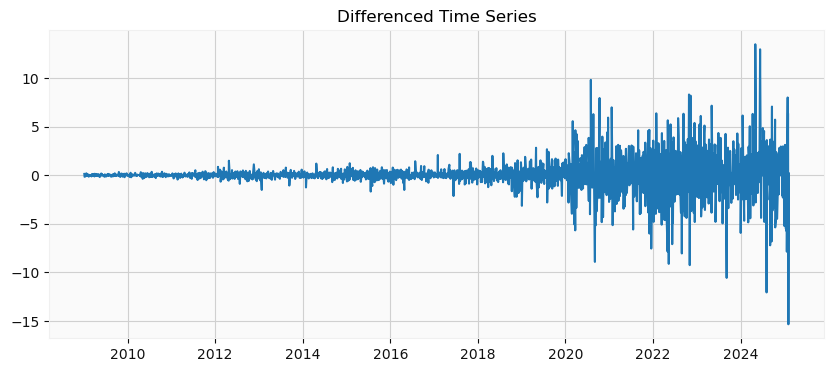

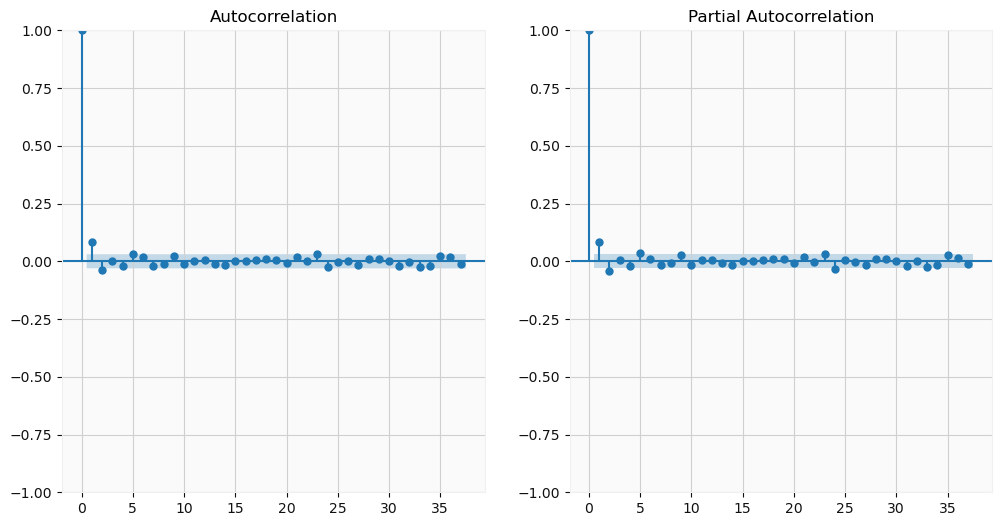

                                     SARIMAX Results                                      
Dep. Variable:                          AAPL_High   No. Observations:                 4201
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -7356.781
Date:                            Tue, 11 Feb 2025   AIC                          14723.561
Time:                                    20:53:20   BIC                          14755.261
Sample:                                01-02-2009   HQIC                         14734.772
                                     - 02-07-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4858      0.066     -7.330      0.000      -0.616      -0.356
ma.L1          0.5675      0.064   

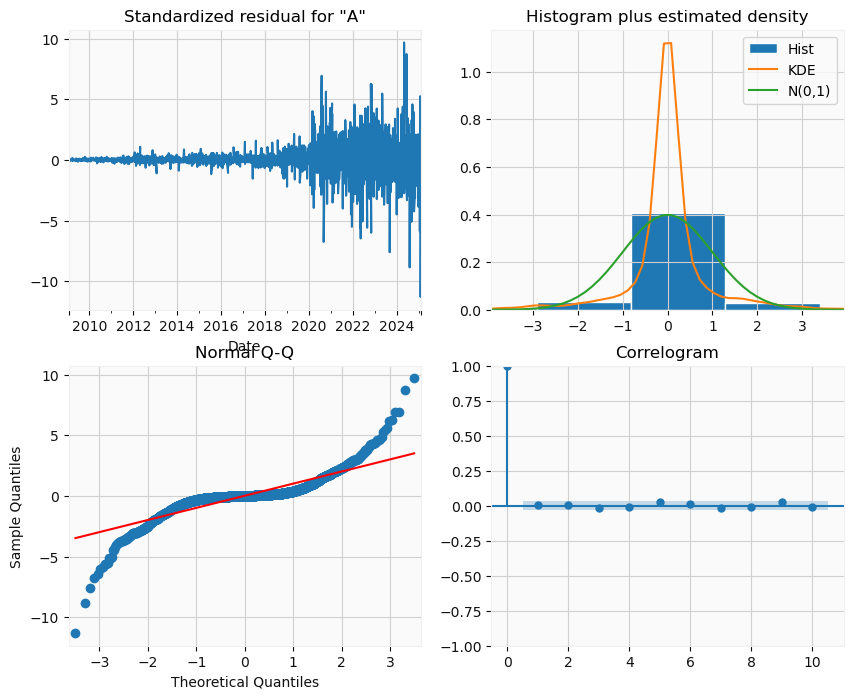

Forecasted Target High Values:
2025-02-10    233.752025
Freq: B, dtype: float64


In [21]:
### Examine and Visualize Baseline Model SARIMAX - Target High

# 'B' business days
df = df.asfreq('B').ffill()  

# Define Target
target_high = df['AAPL_High']

# Step 1: Check for stationarity using the Augmented Dickey-Fuller (ADF) test
result = adfuller(target_high)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] > 0.05:
    print("The time series is non-stationary. Differencing is needed.")
else:
    print("The time series is stationary.")

# Step 2: Differencing if needed to make the series stationary
if result[1] > 0.05:
    target_high_diff = target_high.diff().dropna()
    plt.figure(figsize=(10, 4))
    plt.plot(target_high_diff)
    plt.title('Differenced Time Series')
    plt.show()
else:
    target_high_diff = target_high

# Step 3: Plot ACF and PACF to help select p, d, q
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(target_high_diff, ax=plt.gca())
plt.subplot(122)
plot_pacf(target_high_diff, ax=plt.gca())
plt.show()

# Step 4: Fit the SARIMA model (p, d, q) = (1, 1, 1) and seasonal order (P, D, Q, m) = (1, 1, 1, 12)
# adjust p, d, q, and seasonal values based on ACF/PACF plots.

model = SARIMAX(target_high, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = model.fit(disp=False)

# Step 5: Display model summary
print(sarima_fit.summary())

# Step 6: Plot diagnostics to assess residuals
sarima_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

# Step 7: Forecast the next 1 periods
forecast = sarima_fit.forecast(steps=1)

# Step 8: Display the forecasted values
print("Forecasted Target High Values:")
print(forecast)

ADF Statistic: 1.1525146451755728
p-value: 0.9956408087773172
The time series is non-stationary. Differencing is needed.


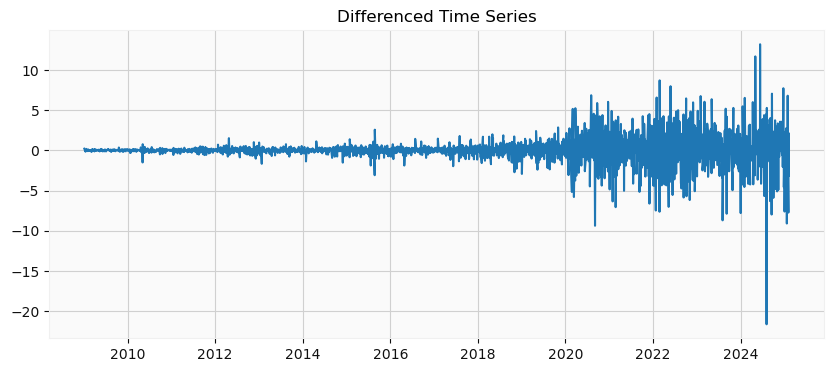

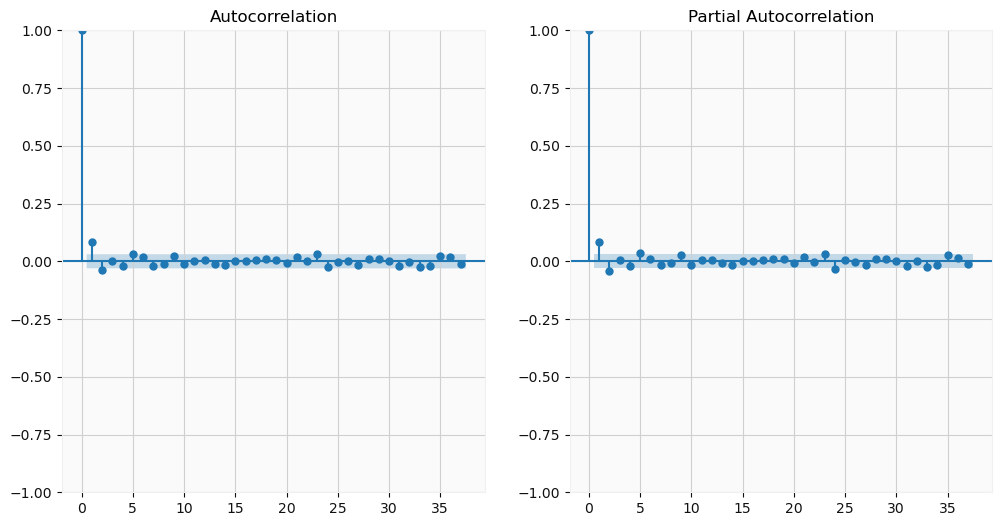

                                     SARIMAX Results                                      
Dep. Variable:                           AAPL_Low   No. Observations:                 4201
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -7451.212
Date:                            Tue, 11 Feb 2025   AIC                          14912.424
Time:                                    20:53:28   BIC                          14944.124
Sample:                                01-02-2009   HQIC                         14923.635
                                     - 02-07-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0910      0.070     -1.297      0.194      -0.229       0.046
ma.L1          0.2065      0.069   

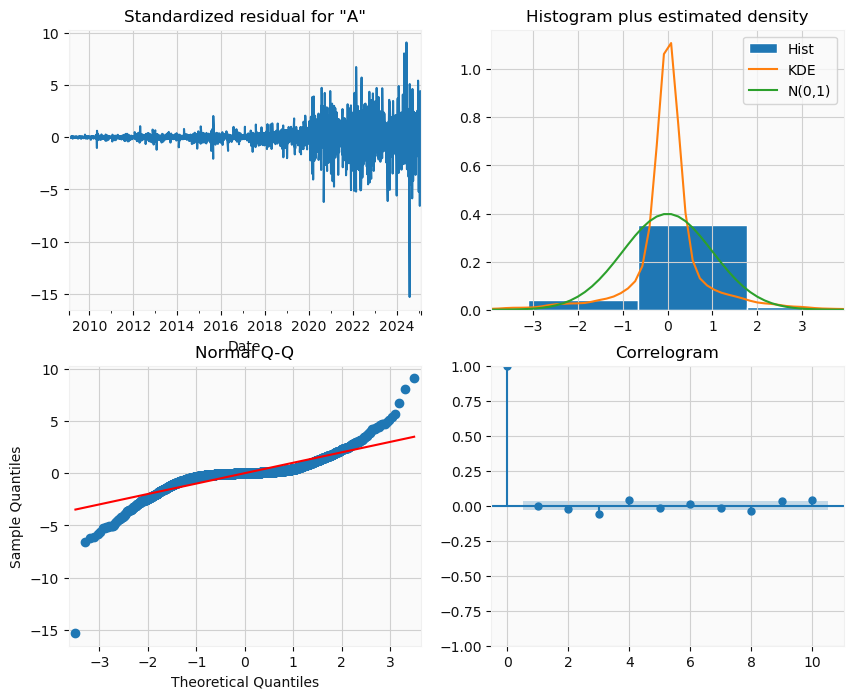

Forecasted Target Low Values:
2025-02-10    226.713559
Freq: B, dtype: float64


In [22]:
### Examine and Visualize Baseline Model SARIMAX - Target Low

# 'B' business days
df = df.asfreq('B').ffill()  

# Define Target
target_low = df['AAPL_Low']

# Step 1: Check for stationarity using the Augmented Dickey-Fuller (ADF) test
result = adfuller(target_high)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] > 0.05:
    print("The time series is non-stationary. Differencing is needed.")
else:
    print("The time series is stationary.")

# Step 2: Differencing if needed to make the series stationary
if result[1] > 0.05:
    target_low_diff = target_low.diff().dropna()
    plt.figure(figsize=(10, 4))
    plt.plot(target_low_diff)
    plt.title('Differenced Time Series')
    plt.show()
else:
    target_low_diff = target_low

# Step 3: Plot ACF and PACF to help select p, d, q
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(target_high_diff, ax=plt.gca())
plt.subplot(122)
plot_pacf(target_high_diff, ax=plt.gca())
plt.show()

# Step 4: Fit the SARIMA model (p, d, q) = (1, 1, 1) and seasonal order (P, D, Q, m) = (1, 1, 1, 12) as an example.
# Adjust p, d, q, and seasonal values based on ACF/PACF plots.
model = SARIMAX(target_low, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = model.fit(disp=False)

# Step 5: Display model summary
print(sarima_fit.summary())

# Step 6: Plot diagnostics to assess residuals
sarima_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

# Step 7: Forecast the next 1 periods
forecast = sarima_fit.forecast(steps=1)

# Step 8: Display the forecasted values
print("Forecasted Target Low Values:")
print(forecast)

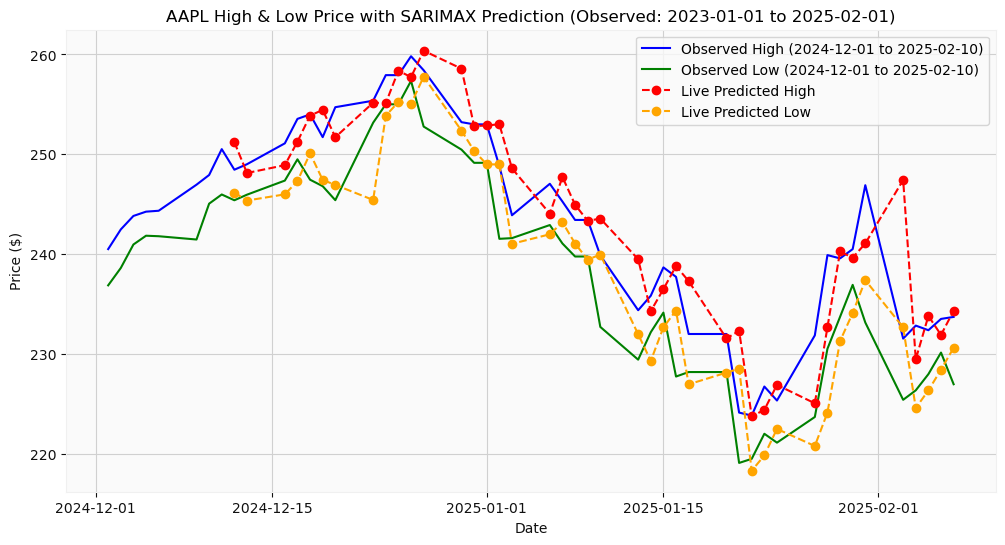

In [25]:
### Visualize Baseline Model SARIMAX Target vs Actual High and Low

sarimax_df = df.copy()

# Convert index to datetime (if not already)
sarimax_df.index = pd.to_datetime(df.index)

# Reserve the last 1% of the data for live testing
live_test_size = int(0.01 * len(sarimax_df))
live_test_data = sarimax_df.iloc[-live_test_size:]
train_data = sarimax_df.iloc[:-live_test_size]

# --- SARIMAX Model for Predicting Target High ---
# Filter all data up to 2025-01-01 for training
train_high = train_data.loc[train_data.index <= '2025-02-01', 'AAPL_High'].dropna()
train_low = train_data.loc[train_data.index <= '2025-02-01', 'AAPL_Low'].dropna()

# Ensure the index is in business day frequency 
train_high = train_high.resample('B').ffill()  
train_low = train_low.resample('B').ffill()

# Train SARIMAX models
sarima_high = SARIMAX(train_high, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=0)
sarima_low = SARIMAX(train_low, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=0)

# --- Live Testing: Make predictions iteratively for the entire live test period ---
live_forecast_high = []
live_forecast_low = []
live_forecast_dates = []

for date in live_test_data.index:
    forecast_high = sarima_high.forecast(steps=1).iloc[0]  
    forecast_low = sarima_low.forecast(steps=1).iloc[0]  
    
    live_forecast_high.append(forecast_high)
    live_forecast_low.append(forecast_low)
    live_forecast_dates.append(date)
    
    # Update models with actual values (walk-forward validation)
    sarima_high = sarima_high.append([live_test_data.loc[date, 'AAPL_High']])
    sarima_low = sarima_low.append([live_test_data.loc[date, 'AAPL_Low']])

# Convert forecasts into DataFrame
live_forecast_df = pd.DataFrame({
    'Forecast_High': live_forecast_high,
    'Forecast_Low': live_forecast_low
}, index=live_forecast_dates)

# --- Filter Observed High & Low for Display Period (2024-12-01 to 2025-02-10) ---
observed_high = df.loc[(df.index >= '2024-12-01') & (df.index <= '2025-02-10'), 'AAPL_High']
observed_low = df.loc[(df.index >= '2024-12-01') & (df.index <= '2025-02-10'), 'AAPL_Low']

# --- PLOTTING ---
plt.figure(figsize=(12, 6))

# Plot observed high & low within the desired range
plt.plot(observed_high.index, observed_high, label='Observed High (2024-12-01 to 2025-02-10)', color='blue')
plt.plot(observed_low.index, observed_low, label='Observed Low (2024-12-01 to 2025-02-10)', color='green')

# Plot the SARIMAX forecast for the live test period
plt.plot(live_forecast_df.index, live_forecast_df['Forecast_High'], marker='o', linestyle='dashed', color='red', label='Live Predicted High')
plt.plot(live_forecast_df.index, live_forecast_df['Forecast_Low'], marker='o', linestyle='dashed', color='orange', label='Live Predicted Low')

# Display legend
plt.legend()
plt.title('AAPL High & Low Price with SARIMAX Prediction (Observed: 2023-01-01 to 2025-02-01)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()


In [27]:
# Convert actual values from the live test period
actual_high = live_test_data['AAPL_High']
actual_low = live_test_data['AAPL_Low']

# Convert forecasted values to Pandas Series to align with actual values
predicted_high = pd.Series(live_forecast_high, index=live_forecast_dates)
predicted_low = pd.Series(live_forecast_low, index=live_forecast_dates)

# Compute MSE and MAE for the entire live period
mae_high = mean_absolute_error(actual_high, predicted_high)
mse_high = mean_squared_error(actual_high, predicted_high)

mae_low = mean_absolute_error(actual_low, predicted_low)
mse_low = mean_squared_error(actual_low, predicted_low)

# Print the results
print(f"Live Test MAE for High: {mae_high:.4f}")
print(f"Live Test MSE for High: {mse_high:.4f}")
print(f"Live Test MAE for Low: {mae_low:.4f}")
print(f"Live Test MSE for Low: {mse_low:.4f}")

Live Test MAE for High: 2.8274
Live Test MSE for High: 16.3985
Live Test MAE for Low: 2.6884
Live Test MSE for Low: 12.9264


In [29]:
print("\n--- Simulated Live Testing ---")

# Use SARIMAX predictions instead of LGBM predictions
predictions_live_y1 = live_forecast_df['Forecast_High'].values  
predictions_live_y2 = live_forecast_df['Forecast_Low'].values  

# Reserve the last 1% of the data for live testing
live_test_size = int(0.01 * len(sarimax_df))
live_test_data = sarimax_df.iloc[-live_test_size:]
train_data = sarimax_df.iloc[:-live_test_size]

# Convert actual values from the live test period
actual_high = live_test_data['AAPL_High']
actual_low = live_test_data['AAPL_Low']

# Convert forecasted values to Pandas Series to align with actual values
predicted_high = pd.Series(live_forecast_high, index=live_forecast_dates)
predicted_low = pd.Series(live_forecast_low, index=live_forecast_dates)

# Compute MSE and MAE for the entire live period
mae_high = mean_absolute_error(actual_high, predicted_high)
mse_high = mean_squared_error(actual_high, predicted_high)

mae_low = mean_absolute_error(actual_low, predicted_low)
mse_low = mean_squared_error(actual_low, predicted_low)

# Print the results
print(f"Live Test MAE for High: {mae_high:.4f}")
print(f"Live Test MSE for High: {mse_high:.4f}")
print(f"Live Test MAE for Low: {mae_low:.4f}")
print(f"Live Test MSE for Low: {mse_low:.4f}")

# --- Grid search for optimal buy and sell rr_values ---
best_buy_rr_value = None
best_sell_rr_value = None
best_cumulative_return = -np.inf
best_returns = []

# Define the range of rr_values to try
buy_rr_values = np.linspace(1, 5, 10)
sell_rr_values = np.linspace(1, 5, 10)

# Iterate over all combinations of buy and sell rr_values
for buy_rr_value in buy_rr_values:
    for sell_rr_value in sell_rr_values:
        returns = []
        entry_price = None
        take_profit = None
        stop_loss = None

        for i in range(len(actual_high) - 2):
            print(f"Iteration {i}: y1_forecast={predicted_high.iloc[i]:.4f}, y2_forecast={predicted_low.iloc[i]:.4f}")

            # Compute risk-reward ratios for buying and selling
            buy_rr_current = ((predicted_high.iloc[i] - actual_high.iloc[i])) / (actual_high.iloc[i] - predicted_low.iloc[i])
            sell_rr_current = ((actual_high.iloc[i] - predicted_low.iloc[i])) / (predicted_high.iloc[i] - actual_high.iloc[i])

            # Buy Entry Condition
            if buy_rr_current > buy_rr_value and entry_price is None:
                print(f"Triggered Buy Entry at index {i}")
                entry_price = actual_low.iloc[i]
                take_profit = predicted_high.iloc[i]
                stop_loss = predicted_low.iloc[i]
                print(f"Entry Price: {entry_price}, TP: {take_profit}, SL: {stop_loss}")

            # Sell Entry Condition
            if sell_rr_current > sell_rr_value and entry_price is None:
                print(f"Triggered Sell Entry at index {i}")
                entry_price = actual_low.iloc[i]
                take_profit = predicted_low.iloc[i]
                stop_loss = predicted_high.iloc[i]
                print(f"Entry Price: {entry_price}, TP: {take_profit}, SL: {stop_loss}")

            # Buy Exit
            if entry_price is not None and take_profit > stop_loss:
                high = actual_high.iloc[i + 1]
                low = actual_low.iloc[i + 1]

                # Take Profit Hit
                if high >= take_profit:
                    return_value = (((take_profit - entry_price) / entry_price) * 100)
                    print(f"TP hit at index {i + 1} | Return: {return_value:.2f}%")
                    returns.append(return_value)
                    entry_price, take_profit, stop_loss = None, None, None

                # Stop Loss Hit
                elif low <= stop_loss:
                    return_value = (((entry_price - stop_loss)/entry_price) * -100)
                    print(f"SL hit at index {i + 1} | Return: {return_value:.2f}%")
                    returns.append(return_value)
                    entry_price, take_profit, stop_loss = None, None, None

            # Sell Exit
            if entry_price is not None and take_profit < stop_loss:
                high = actual_high.iloc[i + 1]
                low = actual_low.iloc[i + 1]
                
                # Take Profit Hit
                if low <= take_profit:
                    return_value = (((entry_price - take_profit) / entry_price) * 100)
                    print(f"TP hit at index {i + 1} | Return: {return_value:.2f}%")
                    returns.append(return_value)
                    entry_price, take_profit, stop_loss = None, None, None
                
                # Stop Loss Hit
                elif high >= stop_loss:
                    return_value = (((stop_loss - entry_price)/entry_price) * -100)
                    print(f"SL hit at index {i + 1} | Return: {return_value:.2f}%")
                    returns.append(return_value)
                    entry_price, take_profit, stop_loss = None, None, None
        
        # Calculate cumulative returns for this pair of buy_rr and sell_rr
        cumulative_returns = np.sum(returns)

        # Update the best parameters if this combination performs better
        if cumulative_returns > best_cumulative_return:
            best_cumulative_return = cumulative_returns
            best_buy_rr_value = buy_rr_value
            best_sell_rr_value = sell_rr_value
            best_returns = returns  



--- Simulated Live Testing ---
Live Test MAE for High: 2.8274
Live Test MSE for High: 16.3985
Live Test MAE for Low: 2.6884
Live Test MSE for Low: 12.9264
Iteration 0: y1_forecast=251.2208, y2_forecast=246.1770
Triggered Buy Entry at index 0
Entry Price: 245.41017310687806, TP: 251.22077456304302, SL: 246.17704159595004
SL hit at index 1 | Return: 0.31%
Iteration 1: y1_forecast=248.1365, y2_forecast=245.3829
Iteration 2: y1_forecast=248.9216, y2_forecast=246.0018
Iteration 3: y1_forecast=251.2733, y2_forecast=247.3314
Iteration 4: y1_forecast=253.8808, y2_forecast=250.0984
Iteration 5: y1_forecast=254.4487, y2_forecast=247.4439
Triggered Sell Entry at index 5
Entry Price: 246.81862390484895, TP: 247.44392083601713, SL: 254.44874449039645
TP hit at index 6 | Return: -0.25%
Iteration 6: y1_forecast=251.7154, y2_forecast=246.9455
Iteration 7: y1_forecast=255.1707, y2_forecast=245.4410
Iteration 8: y1_forecast=255.1292, y2_forecast=253.8650
Iteration 9: y1_forecast=258.3678, y2_forecast=2

In [31]:
# Output the best parameters found
print(f"\nBest Buy RR Value: {best_buy_rr_value}, Best Sell RR Value: {best_sell_rr_value}")
print(f"Best Cumulative Return: {best_cumulative_return:.2f}%")


Best Buy RR Value: 1.8888888888888888, Best Sell RR Value: 3.2222222222222223
Best Cumulative Return: -0.27%


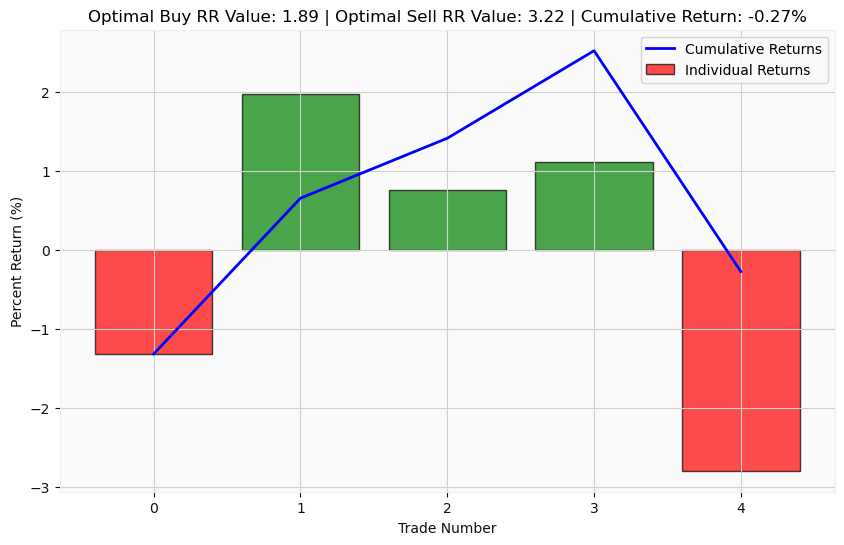

In [33]:
# Compute cumulative returns
cumulative_best_returns = np.cumsum(best_returns)
colors = ['green' if r > 0 else 'red' for r in best_returns]

# Plot individual returns as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(best_returns)), best_returns, color=colors, alpha=0.7, edgecolor='black', label='Individual Returns')

# Plot cumulative returns as a line plot
plt.plot(range(len(best_returns)), cumulative_best_returns, color='blue', linestyle='-', linewidth=2, label='Cumulative Returns')

# Title with best RR values
plt.title(f'Optimal Buy RR Value: {best_buy_rr_value:.2f} | '
          f'Optimal Sell RR Value: {best_sell_rr_value:.2f} | '
          f'Cumulative Return: {best_cumulative_return:.2f}%')

# Labels
plt.xlabel('Trade Number')
plt.ylabel('Percent Return (%)')

# Add legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [35]:
lgbm_df = df.copy()

In [37]:
# Define LGBM Targets - Max High and Min Low over next 1 periods

lgbm_df['target_high'] = lgbm_df['AAPL_High'].shift(-1)
lgbm_df['target_low'] = lgbm_df['AAPL_Low'].shift(-1)


In [39]:
lgbm_df[['target_low', 'AAPL_Low']].head()

,target_low,AAPL_Low
Date,,
2009-01-02,2.789978,2.562772
2009-01-05,2.780347,2.789978
2009-01-06,2.716248,2.780347
2009-01-07,2.709627,2.716248
2009-01-08,2.712637,2.709627


In [41]:
lgbm_df[['target_high', 'AAPL_High']].head()

,target_high,AAPL_High
Date,,
2009-01-02,2.894403,2.739722
2009-01-05,2.924194,2.894403
2009-01-06,2.783657,2.924194
2009-01-07,2.803219,2.783657
2009-01-08,2.810140,2.803219


In [43]:
lgbm_df.describe()

,DX-Y.NYB_Close,SPY_High,SPY_Low,SPY_Close,SPY_Volume,QQQ_High,QQQ_Low,QQQ_Close,QQQ_Volume,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Volume,target_high,target_low
count,4201.000000,4201.000000,4201.000000,4201.000000,4.201000e+03,4201.000000,4201.000000,4201.000000,4.201000e+03,4201.000000,4201.000000,4201.000000,4201.000000,4.201000e+03,4200.000000,4200.000000
mean,91.592649,241.314406,238.612128,240.065379,1.192944e+08,173.299584,170.750002,172.120223,4.965190e+07,64.696408,65.372625,64.052328,64.745573,2.486473e+08,65.387538,64.066969
std,9.635975,139.189663,137.739888,138.523603,7.797889e+07,132.758953,130.754385,131.829207,3.276270e+07,66.550297,67.241437,65.907864,66.616797,2.319573e+08,67.242495,65.908879
min,72.930000,51.933269,49.781776,50.531071,2.027000e+07,23.288740,22.263723,22.359276,7.079300e+06,2.389131,2.467675,2.353320,2.353320,2.323470e+07,2.467675,2.353320
25%,81.370003,118.810655,118.091759,118.778358,6.703230e+07,61.250965,60.673592,61.019974,2.752550e+07,16.047226,16.219427,15.795229,15.987572,8.644040e+07,16.221286,15.817348
50%,93.860001,199.224605,198.234840,198.918060,9.548200e+07,116.877189,116.073765,116.499100,4.017550e+07,29.429714,29.731618,29.165084,29.517216,1.506940e+08,29.769042,29.195356
75%,98.410004,358.403268,351.035984,354.825531,1.469030e+08,280.542651,275.084352,277.956360,6.085660e+07,123.037970,124.363725,121.762652,122.909134,3.541140e+08,124.367546,121.813938
max,114.110001,610.780029,606.799988,609.750000,7.178287e+08,538.282053,533.270084,537.303589,2.882004e+08,257.906429,259.814335,257.347047,258.735504,1.880998e+09,259.814335,257.347047


In [45]:
# Engineer LGBM Features

class CustomAVWAP:
    def __init__(self, period, atr_window):
        self.period = period
        self.atr_window = atr_window
        self.vwap_high = 0
        self.vwap_low = 0
        self.vwap_high_band = 0
        self.vwap_low_band = 0
        self.highest_volume = 0
        self.anchor_index = None
        self.high_price_vol_queue = deque(maxlen=period)
        self.low_price_vol_queue = deque(maxlen=period)
        self.volume_queue = deque(maxlen=period)
        self.high_price_queue = deque(maxlen=period)
        self.low_price_queue = deque(maxlen=period)
        self.close_price_queue = deque(maxlen=period) 
        self.true_range_queue = deque(maxlen=atr_window) 

    def update(self, high, low, close, volume):
        # Calculate high * volume and low * volume
        high_price_vol = high * volume
        low_price_vol = low * volume

        # Add to the rolling windows
        self.high_price_vol_queue.appendleft(high_price_vol)
        self.low_price_vol_queue.appendleft(low_price_vol)
        self.volume_queue.appendleft(volume)
        self.high_price_queue.appendleft(high)
        self.low_price_queue.appendleft(low)
        self.close_price_queue.appendleft(close)

        # Identify the highest volume and set it as the anchor point
        if volume > self.highest_volume:
            self.highest_volume = volume
            self.anchor_index = 0

        # Calculate cumulative volume, high * volume, and low * volume
        cum_high_price_vol = sum(self.high_price_vol_queue)
        cum_low_price_vol = sum(self.low_price_vol_queue)
        cum_volume = sum(self.volume_queue)

        # Calculate True Range (TR)
        if len(self.close_price_queue) > 1:
            prev_close = self.close_price_queue[1]  # Previous close
            tr = max(
                high - low,  # High - Low
                abs(high - prev_close),  # |High - Previous Close|
                abs(low - prev_close)  # |Low - Previous Close|
            )
            self.true_range_queue.appendleft(tr)  # Store the true range value

        # Calculate ATR over the last atr_window periods
        if len(self.true_range_queue) >= self.atr_window:
            atr = np.mean(self.true_range_queue)
        else:
            atr = 0

        # Calculate VWAP based on the anchored data
        if cum_volume > 0:
            self.vwap_high = cum_high_price_vol / cum_volume
            self.vwap_low = cum_low_price_vol / cum_volume

            # Update the bands using ATR
            self.vwap_high_band = self.vwap_high + atr*3
            self.vwap_low_band = self.vwap_low - atr*3

        else:
            self.vwap_high = 0
            self.vwap_low = 0
            self.vwap_high_band = 0
            self.vwap_low_band = 0

        # Return the updated VWAP values and bands
        return self.vwap_high, self.vwap_low, self.vwap_high_band, self.vwap_low_band


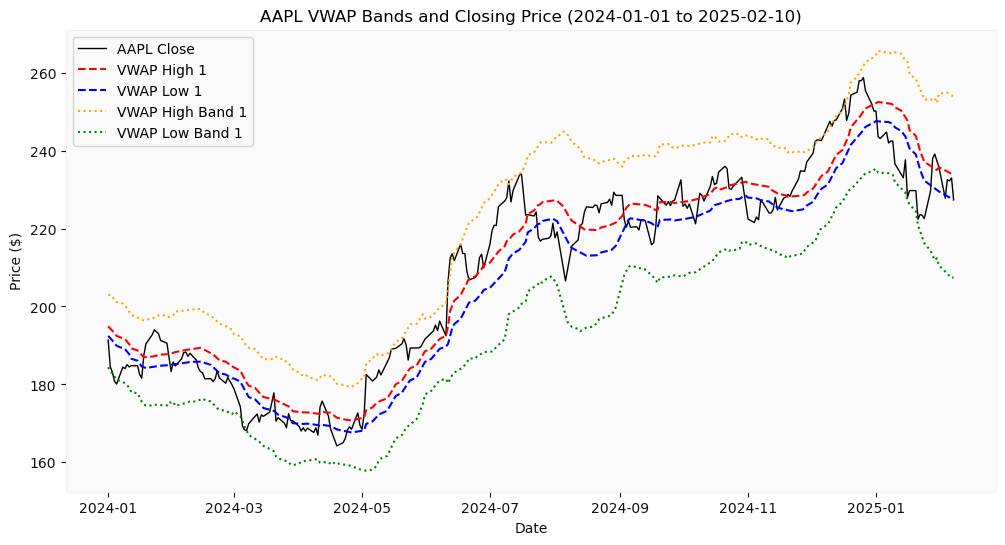

In [47]:
### Engineer LGBM Features Cont.
# Target (AAPL) Short Term Trend - CustomAVWAP 1

# Initialize the CustomAVWAP with a period
avwap_calculator = CustomAVWAP(period=20, atr_window=20) 

# Create new columns for VWAP High and VWAP Low
lgbm_df['vwap_high1'] = 0.0
lgbm_df['vwap_low1'] = 0.0
lgbm_df['vwap_high_band1'] = 0.0
lgbm_df['vwap_low_band1'] = 0.0

# Loop through the DataFrame and update AVWAP
for i, row in df.iterrows():
    vwap_high, vwap_low, vwap_high_band, vwap_low_band = avwap_calculator.update(
        row['AAPL_High'], row['AAPL_Low'], row['AAPL_Close'], row['AAPL_Volume']  # Pass 'close' price as well
    )
    lgbm_df.at[i, 'vwap_high1'] = vwap_high
    lgbm_df.at[i, 'vwap_low1'] = vwap_low
    lgbm_df.at[i, 'vwap_high_band1'] = vwap_high_band
    lgbm_df.at[i, 'vwap_low_band1'] = vwap_low_band

# Ensure index is datetime for proper plotting
lgbm_df.index = pd.to_datetime(lgbm_df.index)

# Filter data for the desired date range
start_date = '2024-01-01'
end_date = '2025-02-10'
lgbm_df_filtered = lgbm_df.loc[(lgbm_df.index >= start_date) & (lgbm_df.index <= end_date)]

# Plot the Closing Price
plt.figure(figsize=(12, 6))
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['AAPL_Close'], label='AAPL Close', color='black', linewidth=1)

# Plot VWAP High and Low
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['vwap_high1'], label='VWAP High 1', color='red', linestyle='dashed')
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['vwap_low1'], label='VWAP Low 1', color='blue', linestyle='dashed')

# Plot VWAP High & Low Bands
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['vwap_high_band1'], label='VWAP High Band 1', color='orange', linestyle='dotted')
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['vwap_low_band1'], label='VWAP Low Band 1', color='green', linestyle='dotted')

# Labels and Legend
plt.title('AAPL VWAP Bands and Closing Price (2024-01-01 to 2025-02-10)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()

# Show the Plot
plt.show()

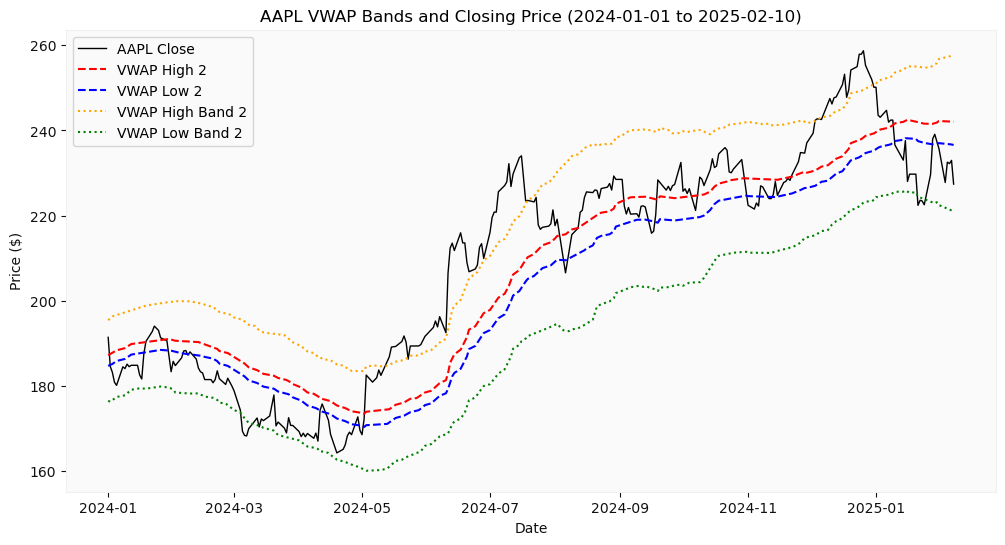

In [49]:
### Engineer LGBM Features Cont.
# Target (AAPL) Long Term Trend - CustomAVWAP 2

# Initialize the CustomAVWAP with a period
avwap_calculator = CustomAVWAP(period=50, atr_window=50) 

# Create new columns for VWAP High and VWAP Low
lgbm_df['vwap_high2'] = 0.0
lgbm_df['vwap_low2'] = 0.0
lgbm_df['vwap_high_band2'] = 0.0
lgbm_df['vwap_low_band2'] = 0.0

# Loop through the DataFrame and update AVWAP
for i, row in df.iterrows():
    vwap_high, vwap_low, vwap_high_band, vwap_low_band = avwap_calculator.update(
        row['AAPL_High'], row['AAPL_Low'], row['AAPL_Close'], row['AAPL_Volume']  # Pass 'close' price as well
    )
    lgbm_df.at[i, 'vwap_high2'] = vwap_high
    lgbm_df.at[i, 'vwap_low2'] = vwap_low
    lgbm_df.at[i, 'vwap_high_band2'] = vwap_high_band
    lgbm_df.at[i, 'vwap_low_band2'] = vwap_low_band

# Ensure index is datetime for proper plotting
lgbm_df.index = pd.to_datetime(lgbm_df.index)

# Filter data for the desired date range
start_date = '2024-01-01'
end_date = '2025-02-10'
lgbm_df_filtered = lgbm_df.loc[(lgbm_df.index >= start_date) & (lgbm_df.index <= end_date)]

# Plot the Closing Price
plt.figure(figsize=(12, 6))
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['AAPL_Close'], label='AAPL Close', color='black', linewidth=1)

# Plot VWAP High and Low
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['vwap_high2'], label='VWAP High 2', color='red', linestyle='dashed')
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['vwap_low2'], label='VWAP Low 2', color='blue', linestyle='dashed')

# Plot VWAP High & Low Bands
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['vwap_high_band2'], label='VWAP High Band 2', color='orange', linestyle='dotted')
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['vwap_low_band2'], label='VWAP Low Band 2', color='green', linestyle='dotted')

# Labels and Legend
plt.title('AAPL VWAP Bands and Closing Price (2024-01-01 to 2025-02-10)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()

# Show the Plot
plt.show()

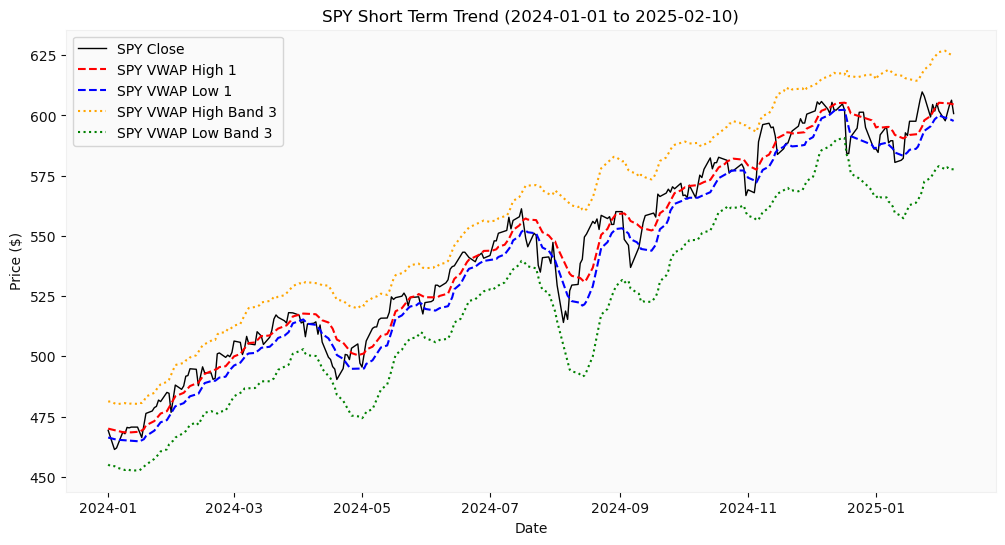

In [51]:
### Engineer LGBM Features Cont.
# Benchmark SPY Trend - CustomAVWAP 3

# Initialize the CustomAVWAP with a period
avwap_calculator = CustomAVWAP(period=10, atr_window=20) 

# Create new columns for VWAP High and VWAP Low
lgbm_df['spy_vwap_high1'] = 0.0
lgbm_df['spy_vwap_low1'] = 0.0
lgbm_df['spy_vwap_high_band1'] = 0.0
lgbm_df['spy_vwap_low_band1'] = 0.0

# Loop through the DataFrame and update AVWAP
for i, row in df.iterrows():
    vwap_high, vwap_low, vwap_high_band, vwap_low_band = avwap_calculator.update(
        row['SPY_High'], row['SPY_Low'], row['SPY_Close'], row['SPY_Volume']  # Pass 'close' price as well
    )
    lgbm_df.at[i, 'spy_vwap_high1'] = vwap_high
    lgbm_df.at[i, 'spy_vwap_low1'] = vwap_low
    lgbm_df.at[i, 'spy_vwap_high_band1'] = vwap_high_band
    lgbm_df.at[i, 'spy_vwap_low_band1'] = vwap_low_band

# Ensure index is datetime for proper plotting
lgbm_df.index = pd.to_datetime(lgbm_df.index)

# Filter data for the desired date range
start_date = '2024-01-01'
end_date = '2025-02-10'
lgbm_df_filtered = lgbm_df.loc[(lgbm_df.index >= start_date) & (lgbm_df.index <= end_date)]

# Plot the Closing Price
plt.figure(figsize=(12, 6))
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['SPY_Close'], label='SPY Close', color='black', linewidth=1)

# Plot VWAP High and Low
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['spy_vwap_high1'], label='SPY VWAP High 1', color='red', linestyle='dashed')
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['spy_vwap_low1'], label='SPY VWAP Low 1', color='blue', linestyle='dashed')

# Plot VWAP High & Low Bands
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['spy_vwap_high_band1'], label='SPY VWAP High Band 3', color='orange', linestyle='dotted')
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['spy_vwap_low_band1'], label='SPY VWAP Low Band 3', color='green', linestyle='dotted')

# Labels and Legend
plt.title('SPY Short Term Trend (2024-01-01 to 2025-02-10)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()

# Show the Plot
plt.show()

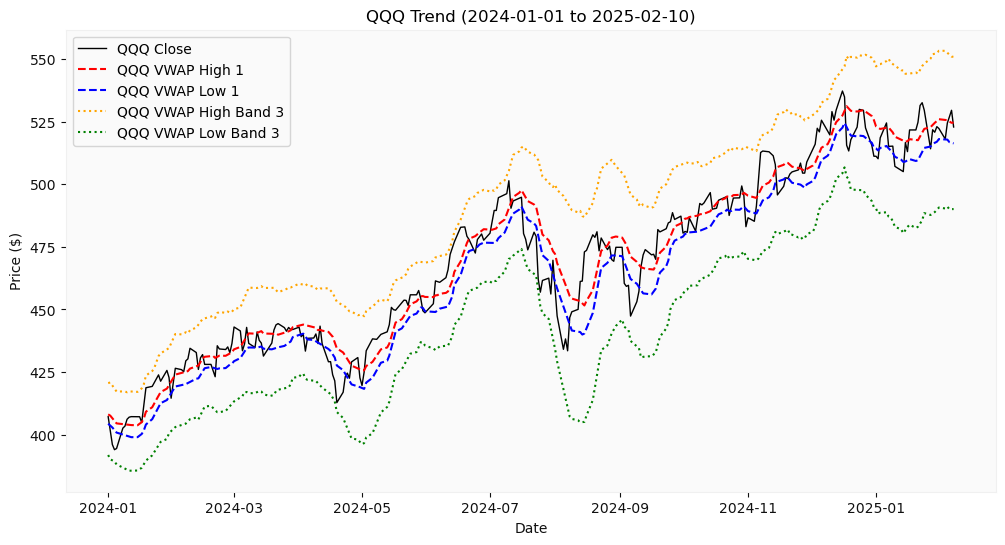

In [53]:
### Engineer LGBM Features Cont.
# Benchmark QQQ Trend - CustomAVWAP 4

# Initialize the CustomAVWAP with a period
avwap_calculator = CustomAVWAP(period=10, atr_window=20) 

# Create new columns for VWAP High and VWAP Low
lgbm_df['qqq_vwap_high1'] = 0.0
lgbm_df['qqq_vwap_low1'] = 0.0
lgbm_df['qqq_vwap_high_band1'] = 0.0
lgbm_df['qqq_vwap_low_band1'] = 0.0

# Loop through the DataFrame and update AVWAP
for i, row in df.iterrows():
    vwap_high, vwap_low, vwap_high_band, vwap_low_band = avwap_calculator.update(
        row['QQQ_High'], row['QQQ_Low'], row['QQQ_Close'], row['QQQ_Volume']  # Pass 'close' price as well
    )
    lgbm_df.at[i, 'qqq_vwap_high1'] = vwap_high
    lgbm_df.at[i, 'qqq_vwap_low1'] = vwap_low
    lgbm_df.at[i, 'qqq_vwap_high_band1'] = vwap_high_band
    lgbm_df.at[i, 'qqq_vwap_low_band1'] = vwap_low_band

# Ensure index is datetime for proper plotting
lgbm_df.index = pd.to_datetime(lgbm_df.index)

# Filter data for the desired date range
start_date = '2024-01-01'
end_date = '2025-02-10'
lgbm_df_filtered = lgbm_df.loc[(lgbm_df.index >= start_date) & (lgbm_df.index <= end_date)]

# Plot the Closing Price
plt.figure(figsize=(12, 6))
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['QQQ_Close'], label='QQQ Close', color='black', linewidth=1)

# Plot VWAP High and Low
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['qqq_vwap_high1'], label='QQQ VWAP High 1', color='red', linestyle='dashed')
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['qqq_vwap_low1'], label='QQQ VWAP Low 1', color='blue', linestyle='dashed')

# Plot VWAP High & Low Bands
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['qqq_vwap_high_band1'], label='QQQ VWAP High Band 3', color='orange', linestyle='dotted')
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['qqq_vwap_low_band1'], label='QQQ VWAP Low Band 3', color='green', linestyle='dotted')

# Labels and Legend
plt.title('QQQ Trend (2024-01-01 to 2025-02-10)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()

# Show the Plot
plt.show()

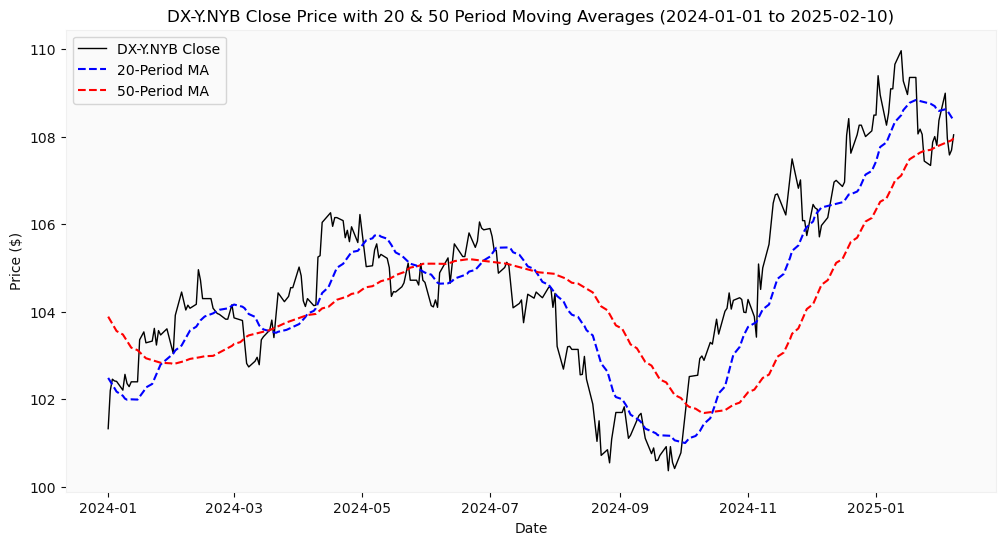

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the index is datetime for proper plotting
lgbm_df.index = pd.to_datetime(lgbm_df.index)

# Calculate the 20-period and 50-period moving averages
lgbm_df['DX-Y.NYB_Close_20MA'] = lgbm_df['DX-Y.NYB_Close'].rolling(window=20).mean()
lgbm_df['DX-Y.NYB_Close_50MA'] = lgbm_df['DX-Y.NYB_Close'].rolling(window=50).mean()

lgbm_df.drop(index=lgbm_df.index[:50], inplace=True)

# Filter data for the desired date range
start_date = '2024-01-01'
end_date = '2025-02-10'
lgbm_df_filtered = lgbm_df.loc[(lgbm_df.index >= start_date) & (lgbm_df.index <= end_date)]

# Plot the Closing Price and Moving Averages
plt.figure(figsize=(12, 6))

# Plot the DX-Y.NYB Close price
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['DX-Y.NYB_Close'], label='DX-Y.NYB Close', color='black', linewidth=1)

# Plot the 20-period moving average
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['DX-Y.NYB_Close_20MA'], label='20-Period MA', color='blue', linestyle='dashed')

# Plot the 50-period moving average
plt.plot(lgbm_df_filtered.index, lgbm_df_filtered['DX-Y.NYB_Close_50MA'], label='50-Period MA', color='red', linestyle='dashed')

# Formatting the plot
plt.title('DX-Y.NYB Close Price with 20 & 50 Period Moving Averages (2024-01-01 to 2025-02-10)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [57]:
print(lgbm_df.columns.tolist())

['DX-Y.NYB_Close', 'SPY_High', 'SPY_Low', 'SPY_Close', 'SPY_Volume', 'QQQ_High', 'QQQ_Low', 'QQQ_Close', 'QQQ_Volume', 'AAPL_Open', 'AAPL_High', 'AAPL_Low', 'AAPL_Close', 'AAPL_Volume', 'target_high', 'target_low', 'vwap_high1', 'vwap_low1', 'vwap_high_band1', 'vwap_low_band1', 'vwap_high2', 'vwap_low2', 'vwap_high_band2', 'vwap_low_band2', 'spy_vwap_high1', 'spy_vwap_low1', 'spy_vwap_high_band1', 'spy_vwap_low_band1', 'qqq_vwap_high1', 'qqq_vwap_low1', 'qqq_vwap_high_band1', 'qqq_vwap_low_band1', 'DX-Y.NYB_Close_20MA', 'DX-Y.NYB_Close_50MA']


In [59]:
import numpy as np

# Replace inf values with NaN so they can be dropped
lgbm_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop all rows that contain NaN values (which includes former inf values)
lgbm_df.dropna(inplace=True)

# Reset index after dropping
lgbm_df.reset_index(drop=True, inplace=True)

# Confirm removal
print("✅ All NaNs and infinite values have been removed from lgbm_df.")
print(f"Remaining rows: {len(lgbm_df)}")


✅ All NaNs and infinite values have been removed from lgbm_df.
Remaining rows: 4150


In [61]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Select only the specified columns for all_features_low and all_features_high
all_features_high = lgbm_df[['AAPL_High', 'AAPL_Close', 'vwap_high1', 'vwap_high_band1', 'vwap_high2', 'vwap_high_band2', 'spy_vwap_high1', 'spy_vwap_high_band1', 
                'qqq_vwap_high1', 'qqq_vwap_high_band1', 'DX-Y.NYB_Close_20MA', 'DX-Y.NYB_Close_50MA']]

all_features_low = lgbm_df[['AAPL_Low','AAPL_Close', 'vwap_low1', 'vwap_low_band1', 'vwap_low2', 'vwap_low_band2', 'spy_vwap_low1', 'spy_vwap_low_band1', 
               'qqq_vwap_low1', 'qqq_vwap_low_band1', 'DX-Y.NYB_Close_20MA', 'DX-Y.NYB_Close_50MA']]


# Create the transformer for scaling
transformer = make_column_transformer(
    (MinMaxScaler(), make_column_selector(dtype_include=['float64', 'int32'])),
    remainder='passthrough'
)

# Ensure column names are strings
X_low = all_features_low.copy()
X_high = all_features_high.copy()
X_low.columns = [str(col) for col in X_low.columns]
X_high.columns = [str(col) for col in X_high.columns]

# Create the scaler objects
scaler_high = MinMaxScaler()
scaler_low = MinMaxScaler()

# Fit the scalers separately for high and low features
X_high_transformed = scaler_high.fit_transform(X_high)
X_low_transformed = scaler_low.fit_transform(X_low)

# Convert transformed arrays back to DataFrames with correct column names
X_high_transformed = pd.DataFrame(X_high_transformed, columns=X_high.columns)
X_low_transformed = pd.DataFrame(X_low_transformed, columns=X_low.columns)

# Verify the transformed DataFrames
print("X_low_transformed columns:", list(X_low_transformed.columns))
print("X_high_transformed columns:", list(X_high_transformed.columns))

X_low_transformed columns: ['AAPL_Low', 'AAPL_Close', 'vwap_low1', 'vwap_low_band1', 'vwap_low2', 'vwap_low_band2', 'spy_vwap_low1', 'spy_vwap_low_band1', 'qqq_vwap_low1', 'qqq_vwap_low_band1', 'DX-Y.NYB_Close_20MA', 'DX-Y.NYB_Close_50MA']
X_high_transformed columns: ['AAPL_High', 'AAPL_Close', 'vwap_high1', 'vwap_high_band1', 'vwap_high2', 'vwap_high_band2', 'spy_vwap_high1', 'spy_vwap_high_band1', 'qqq_vwap_high1', 'qqq_vwap_high_band1', 'DX-Y.NYB_Close_20MA', 'DX-Y.NYB_Close_50MA']


In [63]:
X_low_transformed.head()

,AAPL_Low,AAPL_Close,vwap_low1,vwap_low_band1,vwap_low2,vwap_low_band2,spy_vwap_low1,spy_vwap_low_band1,qqq_vwap_low1,qqq_vwap_low_band1,DX-Y.NYB_Close_20MA,DX-Y.NYB_Close_50MA
0,0.000098,0.000060,0.000011,0.000039,1.189409e-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.358716,0.313051
1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000017,0.000630,0.000501,0.000314,0.000244,0.359899,0.315396
2,0.000105,0.000499,0.000010,0.000015,7.795720e-07,0.000019,0.001342,0.001400,0.000615,0.000634,0.359054,0.317616
3,0.000655,0.000717,0.000057,0.000052,2.520382e-05,0.000036,0.002440,0.002066,0.001032,0.000978,0.354622,0.318878
4,0.000718,0.000729,0.000095,0.000117,4.103960e-05,0.000054,0.004027,0.003632,0.001501,0.001521,0.349021,0.319743


In [65]:
X_high_transformed.head()

,AAPL_High,AAPL_Close,vwap_high1,vwap_high_band1,vwap_high2,vwap_high_band2,spy_vwap_high1,spy_vwap_high_band1,qqq_vwap_high1,qqq_vwap_high_band1,DX-Y.NYB_Close_20MA,DX-Y.NYB_Close_50MA
0,0.000000,0.000060,0.000005,0.000000,0.000003,0.000020,0.000000,0.000000,0.000000,0.000000,0.358716,0.313051
1,0.000022,0.000000,0.000000,0.000019,0.000001,0.000002,0.000452,0.000569,0.000266,0.000330,0.359899,0.315396
2,0.000292,0.000499,0.000020,0.000033,0.000000,0.000000,0.001284,0.001207,0.000607,0.000585,0.359054,0.317616
3,0.000736,0.000717,0.000070,0.000092,0.000028,0.000034,0.002542,0.002857,0.001076,0.001115,0.354622,0.318878
4,0.000703,0.000729,0.000102,0.000101,0.000043,0.000047,0.003935,0.004249,0.001528,0.001496,0.349021,0.319743


In [67]:
y1 = lgbm_df['target_high']
y2 = lgbm_df['target_low']

# Reserve the last 1% of rows for simulated live testing 
live_test_size = int(0.01 * len(lgbm_df))  

# Split the dataset into training + validation, and live test set
X_live_y1 = X_high_transformed.iloc[-live_test_size:].reset_index(drop=True)
X_live_y2 = X_low_transformed.iloc[-live_test_size:].reset_index(drop=True)

y_live_y1 = y1.iloc[-live_test_size:].reset_index(drop=True)
y_live_y2 = y2.iloc[-live_test_size:].reset_index(drop=True)

# Training set excluding live test data
X_train_data_y1 = X_high_transformed.iloc[:-live_test_size].reset_index(drop=True)
X_train_data_y2 = X_low_transformed.iloc[:-live_test_size].reset_index(drop=True)

y1_train_data = y1.iloc[:-live_test_size].reset_index(drop=True)
y2_train_data = y2.iloc[:-live_test_size].reset_index(drop=True)

# Initialize models and metric trackers
mae_progress_y1, mse_progress_y1 = [], []
mae_progress_y2, mse_progress_y2 = [], []
predictions_y1_all, predictions_y2_all = [], []

params = {
    'objective': 'regression',
    'metric': 'l2',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,  
    'num_leaves': 16,  
    'max_depth': 4,  
    'min_data_in_leaf': 20,  
    'bagging_freq': 4,
    'lambda_l1': 0.1,  
    'lambda_l2': 0.1,  
    'bagging_fraction': 0.8,  
    'feature_fraction': 0.8,  
}

n_splits = 10  
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=10)

# Prepare the dataset excluding y_live for y1 and y2
# Training set excluding live test data
X_train_data_y1 = X_high_transformed.iloc[:-live_test_size].reset_index(drop=True)
X_train_data_y2 = X_low_transformed.iloc[:-live_test_size].reset_index(drop=True)

for train_index, test_index in tscv.split(X_train_data_y1):
    train_index = np.arange(0, test_index[0])

    X_train_y1, X_test_y1 = X_train_data_y1.iloc[train_index], X_train_data_y1.iloc[test_index]
    y_train_y1, y_test_y1 = y1_train_data.iloc[train_index], y1_train_data.iloc[test_index]

    X_train_y2, X_test_y2 = X_train_data_y2.iloc[train_index], X_train_data_y2.iloc[test_index]
    y_train_y2, y_test_y2 = y2_train_data.iloc[train_index], y2_train_data.iloc[test_index]

    lgbm_train_data_y1 = lgb.Dataset(X_train_y1, label=y_train_y1)
    lgbm_val_data_y1 = lgb.Dataset(X_test_y1, label=y_test_y1)

    lgbm_train_data_y2 = lgb.Dataset(X_train_y2, label=y_train_y2)
    lgbm_val_data_y2 = lgb.Dataset(X_test_y2, label=y_test_y2)

    lgbm_model_y1 = lgb.train(
        params,
        lgbm_train_data_y1,
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
        valid_sets=[lgbm_train_data_y1, lgbm_val_data_y1],
        valid_names=['train_y1', 'valid_y1']
    )

    lgbm_model_y2 = lgb.train(
        params,
        lgbm_train_data_y2,
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
        valid_sets=[lgbm_train_data_y2, lgbm_val_data_y2],
        valid_names=['train_y2', 'valid_y2']
    )

    # Predictions
    predictions_y1 = lgbm_model_y1.predict(X_test_y1)
    predictions_y2 = lgbm_model_y2.predict(X_test_y2)

    # Store predictions
    predictions_y1_all.extend(predictions_y1)
    predictions_y2_all.extend(predictions_y2)

    # Calculate metrics for y1
    mae_y1 = mean_absolute_error(y_test_y1, predictions_y1)
    mse_y1 = mean_squared_error(y_test_y1, predictions_y1)
    mae_progress_y1.append(mae_y1)
    mse_progress_y1.append(mse_y1)

    # Calculate metrics for y2
    mae_y2 = mean_absolute_error(y_test_y2, predictions_y2)
    mse_y2 = mean_squared_error(y_test_y2, predictions_y2)
    mae_progress_y2.append(mae_y2)
    mse_progress_y2.append(mse_y2)

    print(f"MAE y1: {mae_y1:.4f}, MSE y1: {mse_y1:.4f} | MAE y2: {mae_y2:.4f}, MSE y2: {mse_y2:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 4009, number of used features: 12
[LightGBM] [Info] Start training from score 60.284800
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

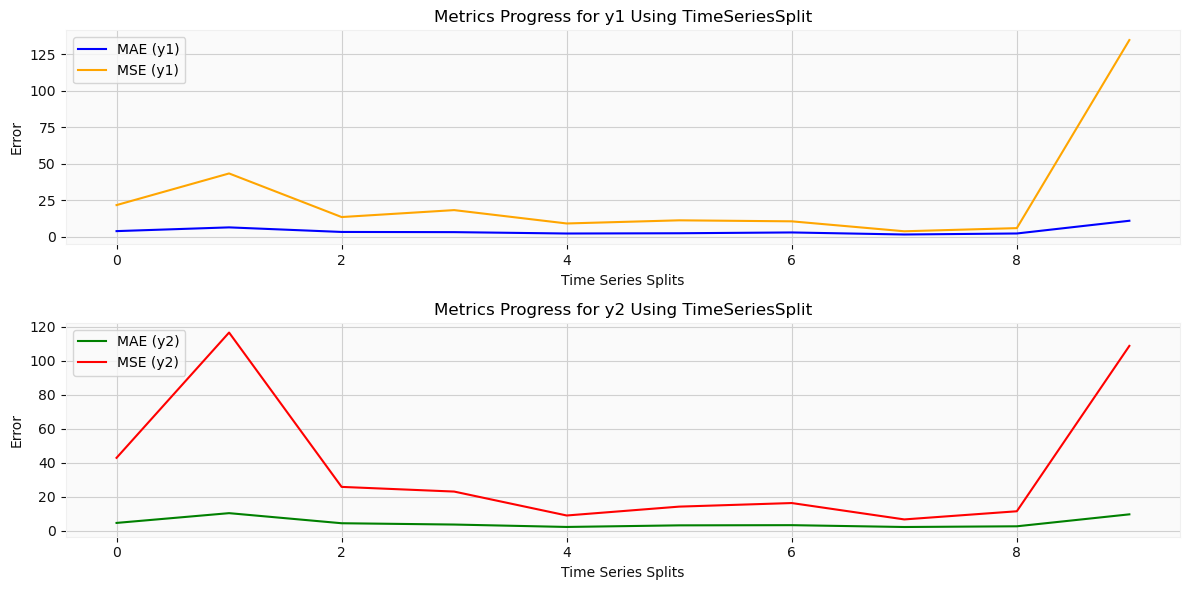

In [68]:
# --- Visualization ---
plt.figure(figsize=(12, 6))

# Plot metrics for y1
plt.subplot(2, 1, 1)
plt.plot(mae_progress_y1, label='MAE (y1)', color='blue')
plt.plot(mse_progress_y1, label='MSE (y1)', color='orange')
plt.title('Metrics Progress for y1 Using TimeSeriesSplit')
plt.xlabel('Time Series Splits')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Plot metrics for y2
plt.subplot(2, 1, 2)
plt.plot(mae_progress_y2, label='MAE (y2)', color='green')
plt.plot(mse_progress_y2, label='MSE (y2)', color='red')
plt.title('Metrics Progress for y2 Using TimeSeriesSplit')
plt.xlabel('Time Series Splits')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [69]:
print("\nMetrics Summary for Each Step:\n")

print("Step    | y1 - MAE    | y1 - MSE    || y2 - MAE    | y2 - MSE")
print("-------------------------------------------------------------")

for step in range(len(mae_progress_y1)):
    print(f"{step + 1:<8} | {mae_progress_y1[step]:<12.4f} | {mse_progress_y1[step]:<12.4f} || {mae_progress_y2[step]:<12.4f} | {mse_progress_y2[step]:<12.4f}")

# Final metrics averages:
average_mae_y1 = np.mean(mae_progress_y1)
average_mse_y1 = np.mean(mse_progress_y1)
average_mae_y2 = np.mean(mae_progress_y2)
average_mse_y2 = np.mean(mse_progress_y2)

print("\nFinal Average Metrics:")
print(f"y1 - Average MAE: {average_mae_y1:.4f}, Average MSE: {average_mse_y1:.4f}")
print(f"y2 - Average MAE: {average_mae_y2:.4f}, Average MSE: {average_mse_y2:.4f}")


Metrics Summary for Each Step:

Step    | y1 - MAE    | y1 - MSE    || y2 - MAE    | y2 - MSE
-------------------------------------------------------------
1        | 3.8654       | 21.7143      || 4.6959       | 42.9598     
2        | 6.4272       | 43.4092      || 10.4370      | 116.6274    
3        | 3.2935       | 13.5115      || 4.5071       | 25.8780     
4        | 3.1684       | 18.2683      || 3.7389       | 23.1312     
5        | 2.2221       | 9.1105       || 2.3254       | 9.0642      
6        | 2.4014       | 11.2644      || 3.2648       | 14.2793     
7        | 2.9497       | 10.5753      || 3.3755       | 16.3805     
8        | 1.5443       | 3.7576       || 2.2954       | 6.7519      
9        | 2.2429       | 5.9183       || 2.7069       | 11.5486     
10       | 10.9624      | 134.8762     || 9.7389       | 108.7852    

Final Average Metrics:
y1 - Average MAE: 3.9077, Average MSE: 27.2406
y2 - Average MAE: 4.7086, Average MSE: 37.5406


In [70]:
print("Checking for NaNs in X_live_y1:")
print(X_live_y1.isna().sum())  # Count NaNs per column

print("\nChecking for NaNs in X_live_y2:")
print(X_live_y2.isna().sum())

print("\nChecking if entire row is NaN in X_live_y1:")
print(X_live_y1[X_live_y1.isna().any(axis=1)])  # Display rows with NaNs

print("\nChecking if entire row is NaN in X_live_y2:")
print(X_live_y2[X_live_y2.isna().any(axis=1)])


Checking for NaNs in X_live_y1:
AAPL_High              0
AAPL_Close             0
vwap_high1             0
vwap_high_band1        0
vwap_high2             0
vwap_high_band2        0
spy_vwap_high1         0
spy_vwap_high_band1    0
qqq_vwap_high1         0
qqq_vwap_high_band1    0
DX-Y.NYB_Close_20MA    0
DX-Y.NYB_Close_50MA    0
dtype: int64

Checking for NaNs in X_live_y2:
AAPL_Low               0
AAPL_Close             0
vwap_low1              0
vwap_low_band1         0
vwap_low2              0
vwap_low_band2         0
spy_vwap_low1          0
spy_vwap_low_band1     0
qqq_vwap_low1          0
qqq_vwap_low_band1     0
DX-Y.NYB_Close_20MA    0
DX-Y.NYB_Close_50MA    0
dtype: int64

Checking if entire row is NaN in X_live_y1:
Empty DataFrame
Columns: [AAPL_High, AAPL_Close, vwap_high1, vwap_high_band1, vwap_high2, vwap_high_band2, spy_vwap_high1, spy_vwap_high_band1, qqq_vwap_high1, qqq_vwap_high_band1, DX-Y.NYB_Close_20MA, DX-Y.NYB_Close_50MA]
Index: []

Checking if entire row is NaN 

In [72]:
print("\nChecking for NaNs in y_live_y1 and y_live_y2:")
print(f"NaNs in y_live_y1: {y_live_y1.isna().sum()}")
print(f"NaNs in y_live_y2: {y_live_y2.isna().sum()}")



Checking for NaNs in y_live_y1 and y_live_y2:
NaNs in y_live_y1: 0
NaNs in y_live_y2: 0


In [77]:
# --- Simulated Live Trading After Training ---
print("\n--- Simulated Live Testing ---")

# Make predictions on the live test set
predictions_live_y1 = lgbm_model_y1.predict(X_live_y1)
predictions_live_y2 = lgbm_model_y2.predict(X_live_y2)

# Evaluate performance on the live test set
mae_live_y1 = mean_absolute_error(y_live_y1, predictions_live_y1)
mse_live_y1 = mean_squared_error(y_live_y1, predictions_live_y1)

mae_live_y2 = mean_absolute_error(y_live_y2, predictions_live_y2)
mse_live_y2 = mean_squared_error(y_live_y2, predictions_live_y2)

print(f"Live Test MAE y1: {mae_live_y1:.4f}, MSE y1: {mse_live_y1:.4f}")
print(f"Live Test MAE y2: {mae_live_y2:.4f}, MSE y2: {mse_live_y2:.4f}")

# --- Grid search for optimal buy and sell rr_values ---
best_buy_rr_value = None
best_sell_rr_value = None
best_cumulative_return = -np.inf
best_returns = []

# Ensure AAPL_High, AAPL_Low, and AAPL_Close are correctly transformed back to their original values
X_live_y1['AAPL_High'] = scaler_high.inverse_transform(
    X_live_y1[X_high.columns]  
)[:, X_high.columns.get_loc("AAPL_High")] 

X_live_y2['AAPL_Low'] = scaler_low.inverse_transform(
    X_live_y2[X_low.columns]
)[:, X_low.columns.get_loc("AAPL_Low")]  

X_live_y2['AAPL_Close'] = scaler_low.inverse_transform(
    X_live_y2[X_low.columns]
)[:, X_low.columns.get_loc("AAPL_Close")]  

# Define the range of rr_values to try
buy_rr_values = np.linspace(1, 5, 10)  
sell_rr_values = np.linspace(1, 5, 10)

# Iterate over all combinations of buy and sell rr_values
for buy_rr_value in buy_rr_values:
    for sell_rr_value in sell_rr_values:
        returns = []
        entry_price = None
        take_profit = None
        stop_loss = None

        for i in range(len(y_live_y1) - 2):
            print(f"Iteration {i}: y1_forecast={predictions_live_y1[i]:.4f}, y2_forecast={predictions_live_y2[i]:.4f}")

            # Compute risk-reward ratios for buying and selling
            buy_rr_current = ((predictions_live_y1[i] - y_live_y1.iloc[i])) / (y_live_y1.iloc[i] - predictions_live_y2[i])
            sell_rr_current = ((y_live_y1.iloc[i] - predictions_live_y2[i])) / (predictions_live_y1[i] - y_live_y1.iloc[i])

            # Buy Entry Condition
            if buy_rr_current > buy_rr_value and entry_price is None:
                print(f"Triggered Buy Entry at index {i}")
                entry_price = X_live_y2.iloc[i]["AAPL_Close"]  
                take_profit = predictions_live_y1[i]
                stop_loss = predictions_live_y2[i]
                print(f"Entry Price: {entry_price}, TP: {take_profit}, SL: {stop_loss}")

            # Sell Entry Condition
            if sell_rr_current > sell_rr_value and entry_price is None:
                print(f"Triggered Sell Entry at index {i}")
                entry_price = X_live_y2.iloc[i]["AAPL_Close"]  
                take_profit = predictions_live_y2[i]
                stop_loss = predictions_live_y1[i]
                print(f"Entry Price: {entry_price}, TP: {take_profit}, SL: {stop_loss}")

            # Buy Exit
            if entry_price is not None and take_profit > stop_loss:
                high = X_live_y1.iloc[i + 1]["AAPL_High"]
                low = X_live_y2.iloc[i + 1]["AAPL_Low"]

                # Take Profit Hit
                if high >= take_profit:  
                    return_value = (((take_profit - entry_price) / entry_price) * 100) 
                    print(f"TP hit at index {i + 1} | Return: {return_value:.2f}%")
                    returns.append(return_value)
                    entry_price, take_profit, stop_loss = None, None, None

                # Stop Loss Hit
                elif low <= stop_loss:  
                    return_value = (((entry_price - stop_loss)/entry_price) * -100) 
                    print(f"SL hit at index {i + 1} | Return: {return_value:.2f}%")
                    returns.append(return_value)
                    entry_price, take_profit, stop_loss = None, None, None

            # Sell Exit
            if entry_price is not None and take_profit < stop_loss:
                high = X_live_y1.iloc[i + 1]["AAPL_High"]
                low = X_live_y2.iloc[i + 1]["AAPL_Low"]
                
                # Take Profit Hit
                if low <= take_profit:  
                    return_value = (((entry_price - take_profit) / entry_price) * 100) 
                    print(f"TP hit at index {i + 1} | Return: {return_value:.2f}%")
                    returns.append(return_value)
                    entry_price, take_profit, stop_loss = None, None, None
                
                # Stop Loss Hit
                elif high >= stop_loss:  
                    return_value = (((stop_loss - entry_price)/entry_price) * -100) 
                    print(f"SL hit at index {i + 1} | Return: {return_value:.2f}%")
                    returns.append(return_value)
                    entry_price, take_profit, stop_loss = None, None, None
        
        # Calculate cumulative returns for this pair of buy_rr and sell_rr
        cumulative_returns = np.sum(returns)

        # Update the best parameters if this combination performs better and store the best set of returns
        if cumulative_returns > best_cumulative_return:
            best_cumulative_return = cumulative_returns
            best_buy_rr_value = buy_rr_value
            best_sell_rr_value = sell_rr_value
            best_returns = returns 

# Output the best parameters found
print(f"\nBest Buy RR Value: {best_buy_rr_value}, Best Sell RR Value: {best_sell_rr_value}")
print(f"Best Cumulative Return: {best_cumulative_return:.2f}%")


--- Simulated Live Testing ---
Live Test MAE y1: 10.6819, MSE y1: 184.0976
Live Test MAE y2: 9.4502, MSE y2: 149.1076
Iteration 0: y1_forecast=233.6025, y2_forecast=231.3907
Iteration 1: y1_forecast=233.6329, y2_forecast=231.3907
Iteration 2: y1_forecast=233.6103, y2_forecast=231.3907
Iteration 3: y1_forecast=233.6103, y2_forecast=231.3907
Iteration 4: y1_forecast=233.7024, y2_forecast=231.4326
Iteration 5: y1_forecast=233.7024, y2_forecast=231.4326
Iteration 6: y1_forecast=233.7024, y2_forecast=231.4326
Iteration 7: y1_forecast=233.7024, y2_forecast=231.4326
Iteration 8: y1_forecast=233.7024, y2_forecast=231.4326
Iteration 9: y1_forecast=233.6521, y2_forecast=231.3602
Iteration 10: y1_forecast=233.7674, y2_forecast=231.3602
Iteration 11: y1_forecast=233.7674, y2_forecast=231.3602
Iteration 12: y1_forecast=233.7674, y2_forecast=231.3602
Iteration 13: y1_forecast=233.7674, y2_forecast=231.3602
Iteration 14: y1_forecast=233.7674, y2_forecast=231.3602
Iteration 15: y1_forecast=233.5533, 

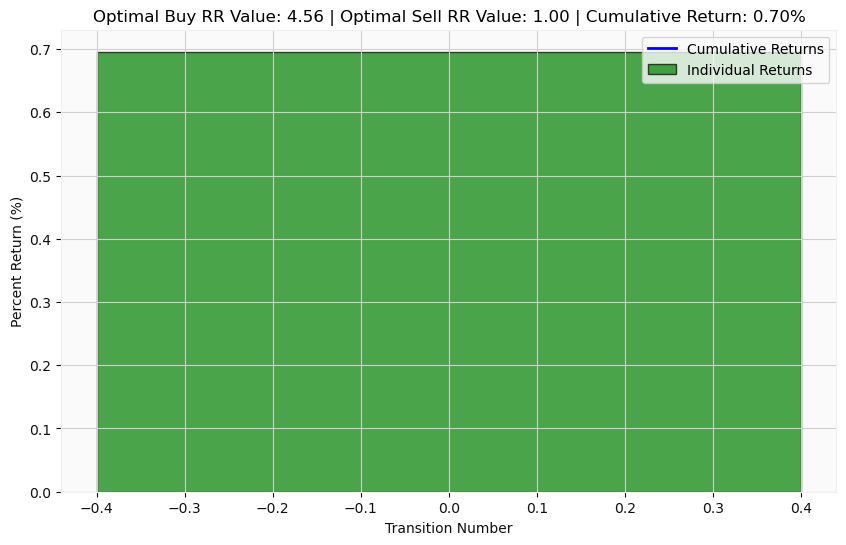

In [79]:
# --- Plot the best individual and cumulative returns ---
cumulative_best_returns = np.cumsum(best_returns)
colors = ['green' if r > 0 else 'red' for r in best_returns]

plt.figure(figsize=(10, 6))
plt.bar(range(len(best_returns)), best_returns, color=colors, alpha=0.7, edgecolor='black', label='Individual Returns')
plt.plot(range(len(best_returns)), cumulative_best_returns, color='blue', linestyle='-', linewidth=2, label='Cumulative Returns')
plt.title(f'Optimal Buy RR Value: {best_buy_rr_value:.2f} | Optimal Sell RR Value: {best_sell_rr_value:.2f} | Cumulative Return: {best_cumulative_return:.2f}%')
plt.xlabel('Transition Number')
plt.ylabel('Percent Return (%)')

plt.legend()
plt.grid(True)
plt.show()